In [2]:
!pip install utils
!pip install obspy

# Libraries for neural networks
import torch
import torch.nn as nn

# Libraries for data processing and analysis
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Libraries for seismic data and utilities
from obspy import read
from obspy import UTCDateTime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility functions and external models (custom imports, ensure these are implemented)
from utils import *  # Ensure `utils.py` exists and contains the required functions
# from autoencoder_model import *  # Uncomment if `autoencoder_model.py` is implemented

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)  # Torch seed
np.random.seed(seed)  # NumPy seed

# Set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')  # Use the latest Seaborn dark grid style
sns.set_context("talk")  # Larger font size for better visuals


  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=8be2a140315f4e09ac737f9e167b1df0f7c2ee88a4753264d4d50ce5947cf54c
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 86.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [3]:
from sklearn.neighbors import NearestNeighbors  # For KNN implementation


In [5]:
def detect_anomalies(filename, knn_k=5, autoencoder_epochs=100, anomaly_threshold=95):
    """
    Detects anomalies in seismic data using Autoencoder and KNN methods and outputs cleaned waves.

    Args:
        filename (str): Path to the seismic file (readable by ObsPy).
        knn_k (int): Number of neighbors for KNN-based anomaly detection.
        autoencoder_epochs (int): Number of epochs for training the Autoencoder.
        anomaly_threshold (float): Percentile threshold for anomalies.

    Outputs:
        - Original waveform with anomalies (Autoencoder and KNN).
        - Cleaned waveform (rectified) without anomalies (Autoencoder and KNN) in separate graphs, with consistent scales.
    """
    # Load seismic data
    stream = read(filename)
    trace = stream[0]
    seismic_data = trace.data
    times = trace.times()

    # Normalize the data
    seismic_data = (seismic_data - seismic_data.min()) / (seismic_data.max() - seismic_data.min())
    data_tensor = torch.FloatTensor(seismic_data).unsqueeze(1)

    # ------------------ Autoencoder Model ------------------
    class Autoencoder(nn.Module):
        def __init__(self):
            super(Autoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(1, 32),
                nn.ReLU(),
                nn.Linear(32, 8),
                nn.ReLU()
            )
            self.decoder = nn.Sequential(
                nn.Linear(8, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    # Train Autoencoder
    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(autoencoder_epochs):
        output = model(data_tensor)
        loss = criterion(output, data_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Reconstruction error and anomaly detection
    reconstructed = model(data_tensor).detach().numpy().flatten()
    reconstruction_error = np.abs(seismic_data - reconstructed)
    autoencoder_threshold = np.percentile(reconstruction_error, anomaly_threshold)
    autoencoder_anomalies = reconstruction_error > autoencoder_threshold

    # Create cleaned wave for Autoencoder
    cleaned_wave_autoencoder = seismic_data.copy()
    cleaned_wave_autoencoder[autoencoder_anomalies] = reconstructed[autoencoder_anomalies]

    # ------------------ KNN Model ------------------
    seismic_data_reshaped = seismic_data.reshape(-1, 1)
    knn = NearestNeighbors(n_neighbors=knn_k)
    knn.fit(seismic_data_reshaped)
    distances, _ = knn.kneighbors(seismic_data_reshaped)
    knn_anomaly_scores = distances[:, -1]
    knn_threshold = np.percentile(knn_anomaly_scores, anomaly_threshold)
    knn_anomalies = knn_anomaly_scores > knn_threshold

    # Create cleaned wave for KNN
    cleaned_wave_knn = seismic_data.copy()
    cleaned_wave_knn[knn_anomalies] = np.mean(seismic_data)  # Replace with average or nearby values

    # ------------------ Set Common Scale ------------------
    # Calculate y-limits based on the original waveform
    y_min, y_max = seismic_data.min(), seismic_data.max()

    # ------------------ Visualization ------------------
    # Autoencoder: Original and Anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(times, seismic_data, label="Original Wave", alpha=0.7)
    plt.scatter(times[autoencoder_anomalies], seismic_data[autoencoder_anomalies], color='red', label="Anomalies (Autoencoder)")
    plt.ylim(y_min, y_max)  # Set the same scale
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Velocity')
    plt.title('Seismic Trace with Anomalies (Autoencoder)')
    plt.legend()
    plt.show()

    # Autoencoder: Cleaned Wave
    plt.figure(figsize=(10, 6))
    plt.plot(times, cleaned_wave_autoencoder, label="Cleaned Wave (Autoencoder)", color='green')
    plt.ylim(y_min, y_max)  # Set the same scale
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Velocity')
    plt.title('Seismic Trace: Cleaned Wave (Autoencoder)')
    plt.legend()
    plt.show()

    # KNN: Original and Anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(times, seismic_data, label="Original Wave", alpha=0.7)
    plt.scatter(times[knn_anomalies], seismic_data[knn_anomalies], color='blue', label="Anomalies (KNN)")
    plt.ylim(y_min, y_max)  # Set the same scale
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Velocity')
    plt.title('Seismic Trace with Anomalies (KNN)')
    plt.legend()
    plt.show()

    # KNN: Cleaned Wave
    plt.figure(figsize=(10, 6))
    plt.plot(times, cleaned_wave_knn, label="Cleaned Wave (KNN)", color='purple')
    plt.ylim(y_min, y_max)  # Set the same scale
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Velocity')
    plt.title('Seismic Trace: Cleaned Wave (KNN)')
    plt.legend()
    plt.show()


In [7]:
file_path = r"/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed" #File Manually downloaded from the full data archive

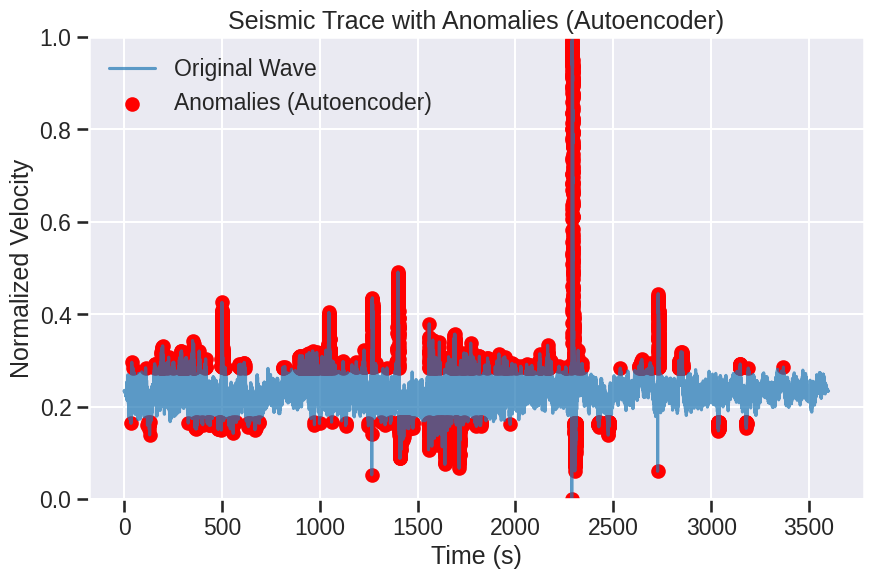

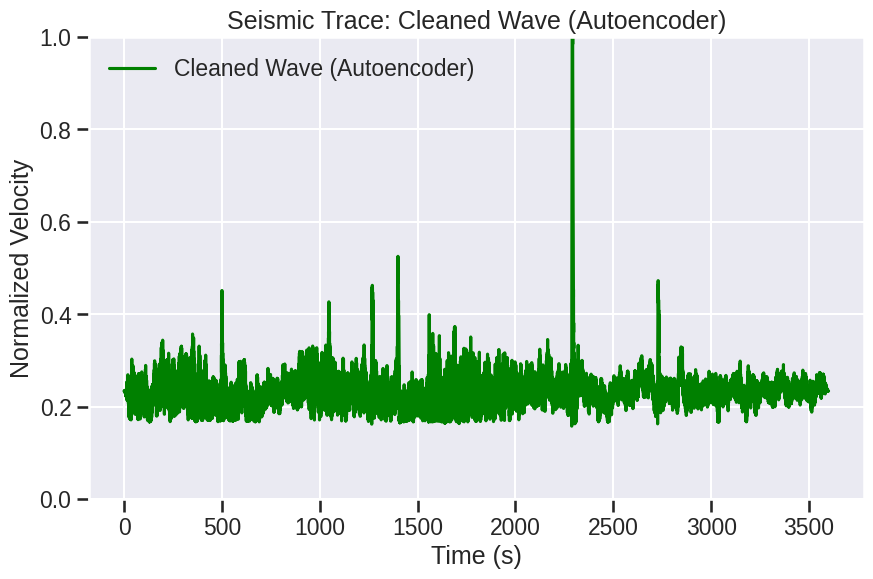

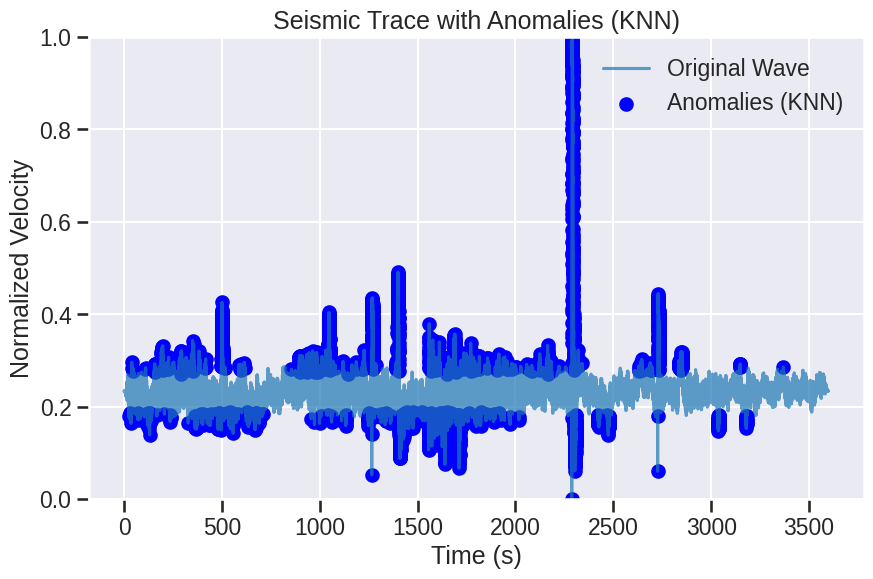

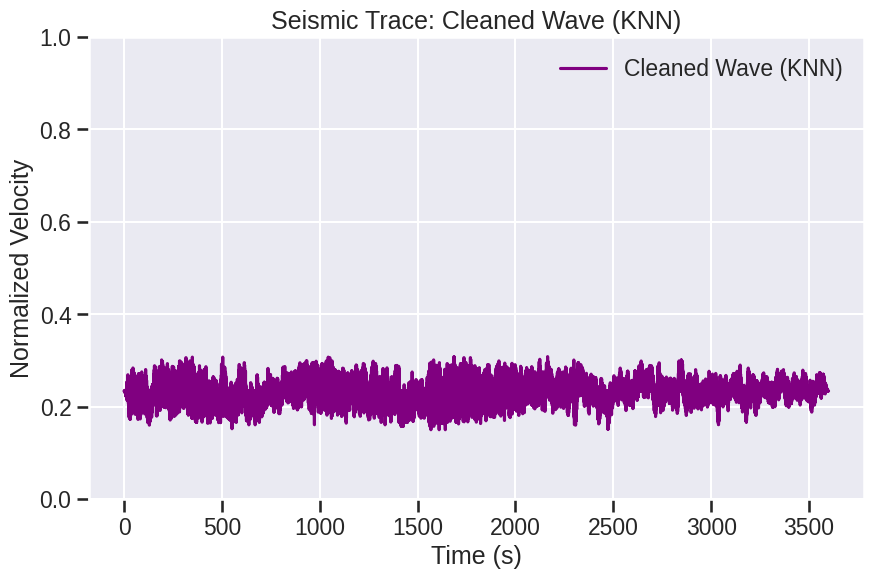

In [8]:
detect_anomalies(file_path)

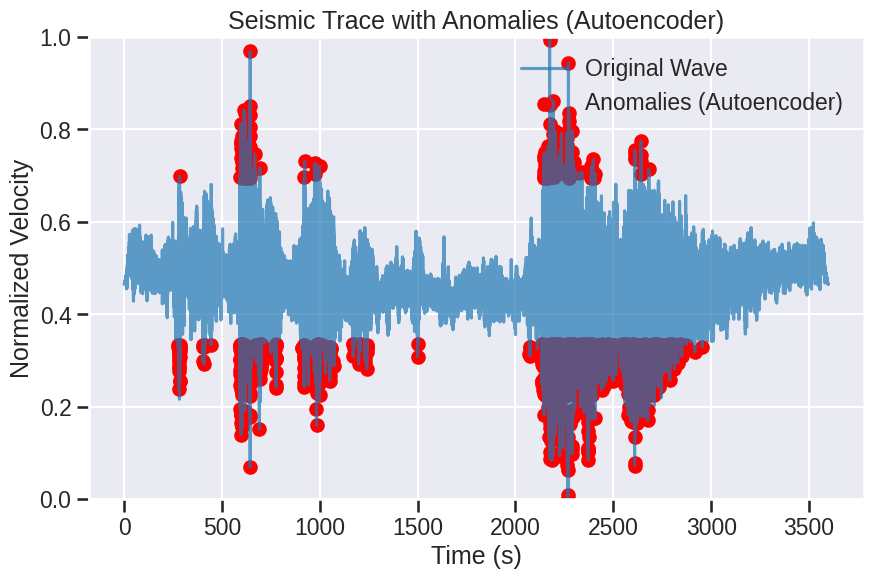

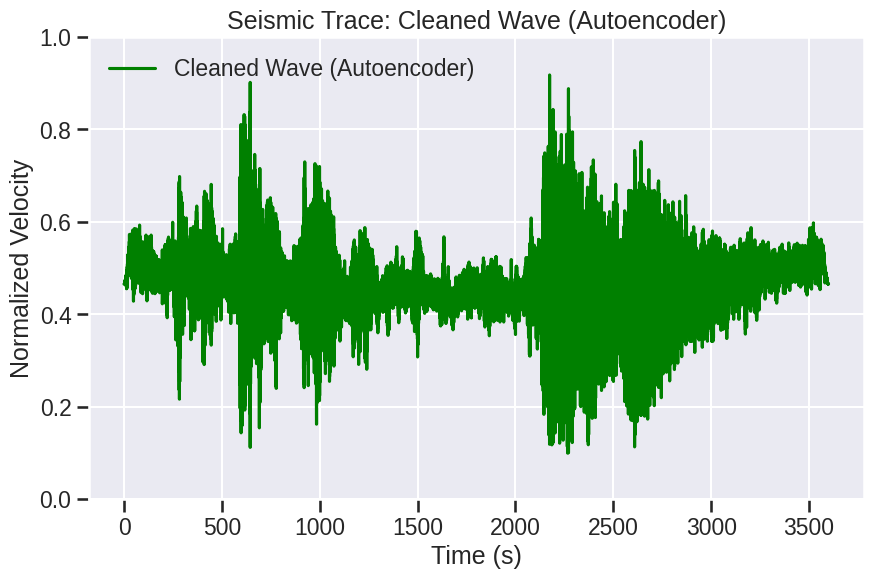

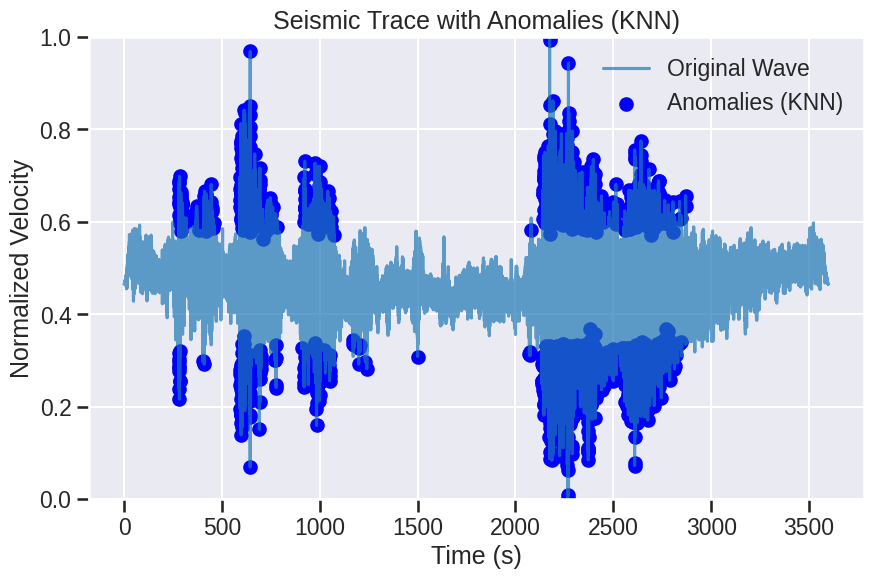

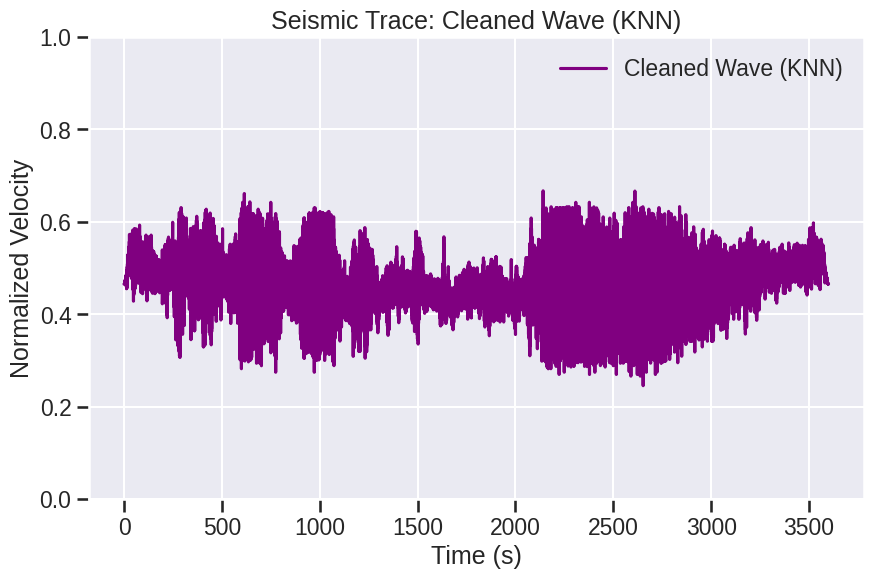

In [10]:
file_path="/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed"
detect_anomalies(file_path,7,1000,97)